In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from rdkit.Chem import Descriptors
from rdkit import Chem
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix

# Preprocessing
Using the preprocessing and PCA from RFE on features.ipynb from 'Bjorn' around 22:30
Removed the split into test and train data in the beginning, because it will make changing the test and train data division at the end more difficult and thus make the testing of variance on the models more difficult

## Reading files into dataframes 

In [3]:
# Read file
original_df = pd.read_csv('tested_molecules_1.csv')

# Split the column
original_df[['SMILES', 'ALDH1_inhibition']] = original_df['SMILES,"ALDH1_inhibition"'].str.split(',', expand=True)
original_df.drop('SMILES,"ALDH1_inhibition"', axis=1, inplace=True)

original_df['ALDH1_inhibition'] = original_df['ALDH1_inhibition'].str.strip('"')
# Read file for original_df_test
original_df_test = pd.read_csv('tested_molecules_2.csv')

original_df_test = pd.read_csv('tested_molecules_2.csv')
original_df_test[['SMILES', 'ALDH1_inhibition']] = original_df_test['SMILES;ALDH1_inhibition'].str.split(';', expand=True)
original_df_test.drop('SMILES;ALDH1_inhibition', axis=1, inplace=True)

combined_df = pd.concat([original_df, original_df_test], ignore_index=True)

X = combined_df.drop('ALDH1_inhibition', axis=1)
y = combined_df['ALDH1_inhibition']

all_descriptors = [desc[0] for desc in Descriptors.descList]
descriptor_data_list_original = []
for i, row in X.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in all_descriptors]
    descriptor_data_list_original.append(descriptor_values)

descriptor_df = pd.DataFrame(descriptor_data_list_original, columns=all_descriptors)

In [6]:
new_df_variables = descriptor_df.copy()
corr_matrix = new_df_variables.corr().abs() #Numeric_only=True removed, because it gave an error
mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)

# Select upper triangle of correlation matrix using the boolean mask
upper = corr_matrix.where(mask)

# Find index of columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop the columns
new_df_variables.drop(columns=to_drop, inplace=True)

In [7]:
# Scaling the data 
df_copied = new_df_variables.copy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copied)
df_scaled = pd.DataFrame(df_scaled, columns=df_copied.columns)

In [8]:
def remove_features_with_low_variance(data, threshold):
    low_variance_features = []
    
    for feature in data.columns:
        var = data[feature].var()
        
        if var < threshold:
            low_variance_features.append(feature)
    
    # Remove the features with low variance
    data = data.drop(low_variance_features, axis=1)
    
    return data
data_filtered = remove_features_with_low_variance(df_scaled, threshold=0.005)


In [9]:
# Had no clue how to remove points, based on statistic, so just used chatGPT to get the data with lower amount of 
# than 50 outliers
def remove_features_with_outliers(data, threshold):
    outlier_count = []
    features_to_remove = []
    
    for feature in data.columns:
        # Calculate the IQR (Interquartile Range) for the current feature
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count the number of outliers
        outliers_count = ((data[feature] < lower_bound) | (data[feature] > upper_bound)).sum()
        
        # Append the feature and its outlier count to the list
        outlier_count.append((feature, outliers_count))
        
        # Check if the feature has more outliers than the threshold
        if outliers_count > threshold:
            features_to_remove.append(feature)
    
    # Sort the features based on the outlier count (from lowest to highest)
    outlier_count.sort(key=lambda x: x[1])
    
    # Remove the features with more outliers than the threshold
    data = data.drop(features_to_remove, axis=1)
    
    return data
data_filtered = remove_features_with_outliers(data_filtered, 90)

In [10]:
# Calculate the mean for each column
mean = data_filtered.mean()

# Calculate the standard deviation for each column
std_dev = data_filtered.std()

# Iterate over each column in the dataframe
outlier_features = []
for column in data_filtered.columns:
    # Calculate the absolute difference between values and the mean
    diff = abs(data_filtered[column] - mean[column])
    
    # Check if the difference is more than four standard deviations
    if (diff > 8 * std_dev[column]).any():
        outlier_features.append(column)

# Drop the outlier features from the dataframe
data_filtered = data_filtered.drop(columns=outlier_features)

Calculating optimal features with RFECV, TAKES A LONG TIME

In [15]:
X = data_filtered
boosting_estimator = AdaBoostClassifier(n_estimators=100, random_state=42)

# Create RFECV with the AdaBoost classifier as the estimator
rfecv = RFECV(estimator=boosting_estimator, cv=5, step=1, scoring='accuracy')

# Fit RFECV on the training data
rfecv.fit(X, y)

# Get the selected features
selected_features = X.columns[rfecv.support_]

print('Optimal number of features:', rfecv.n_features_)
print('Best features:', selected_features)

# Fit AdaBoost on the training data
boosting_estimator.fit(X, y)

# Calculate feature importances
feature_importances = boosting_estimator.feature_importances_

df_selected_features = data_filtered.loc[:, selected_features]

Optimal number of features: 18
Best features: Index(['MaxEStateIndex', 'qed', 'MolWt', 'MaxPartialCharge',
       'MinPartialCharge', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI',
       'BCUT2D_MRHI', 'BalabanJ', 'BertzCT', 'Kappa2', 'PEOE_VSA7', 'SMR_VSA1',
       'SMR_VSA10', 'SlogP_VSA5', 'VSA_EState8', 'MolLogP'],
      dtype='object')


## PCA

In [18]:
# Create principal components
pca = PCA()
df_pca = pca.fit_transform(df_selected_features)
# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(df_pca.shape[1])]
df_pca_converted = pd.DataFrame(df_pca, columns=component_names)

df_pca_converted.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,0.524092,0.137517,0.181926,0.125913,-0.184487,-0.004333,0.092854,0.075539,-0.171829,0.005978,0.059888,-0.071555,-0.032207,-0.044872,0.083316,0.105194,-0.015065,0.028838
1,0.174428,0.309373,-0.092610,0.000579,-0.128074,0.083918,0.010308,0.094354,-0.037947,-0.018837,-0.062700,-0.073437,0.090225,-0.005407,-0.008119,0.015137,0.014836,-0.020391
2,0.633657,0.180584,0.539654,0.252055,-0.036576,-0.006382,-0.018049,-0.003968,-0.026050,-0.052728,0.047096,-0.045798,-0.003352,0.144095,-0.013572,-0.002306,0.055732,0.031482
3,0.074288,0.007266,-0.231351,-0.333269,0.231452,0.130549,0.021598,-0.097725,0.098042,-0.042194,0.257006,0.031978,0.167239,0.012117,0.051995,-0.057340,-0.031677,0.028902
4,0.282885,0.294472,-0.179994,-0.333280,0.019560,-0.042268,-0.013266,0.068431,-0.123438,-0.005909,-0.049559,0.030564,-0.114220,0.010742,-0.025426,-0.023814,-0.008350,0.007111


(0.3875400502134756, 0.1271640813082535)

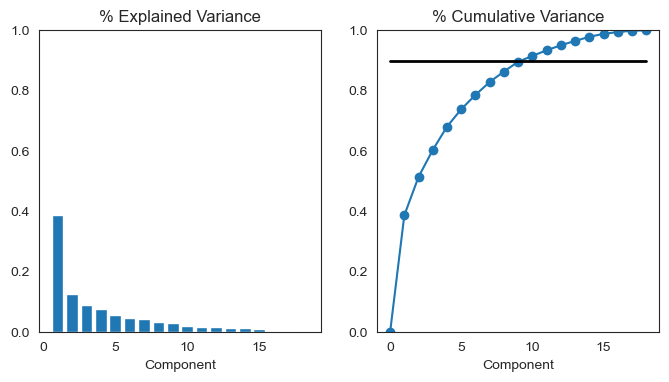

In [179]:
# Create figure
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)

# Explained variance
# Explained variance
evr = pca.explained_variance_ratio_
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
)

# Cumulative Variance
# Cumaltive Variance
cv = np.cumsum(evr)
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].plot([0, n], [0.9, 0.9], color='k', linestyle='-', linewidth=2)
axs[1].set(
    xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
)
        
# Set up figure
fig.set(figwidth=8, dpi=100);
evr[0],evr[1]

Text(0.5, 1.0, 'Scores separated by ALDH1 inhibition')

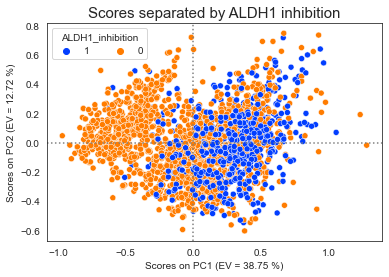

In [180]:
def plot_scores(label, PC_1, PC_2, X, y):
    labels = y.values
    sns.set_style('white')
    sns.scatterplot(x=df_pca[:, PC_1], y=df_pca[:, PC_2], hue=labels, palette='bright')

    plt.axhline(y=0, color='gray', linestyle='dotted')    
    plt.axvline(x=0, color='gray', linestyle='dotted')

    plt.legend(loc='best', ncol=2, title=label)

# Call the function with the appropriate arguments
plot_scores(label='ALDH1_inhibition', PC_1=0, PC_2=1, X=df_pca_converted, y=y)

plt.xlabel('Scores on PC1 (EV = 38.75 %)')
plt.ylabel('Scores on PC2 (EV = 12.72 %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

In [ ]:
selected_descriptors = [desc for desc in all_descriptors if desc in df_selected_features.columns]
descriptor_data_list_2 = []
for i, row in X_test_old.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in selected_descriptors]
    descriptor_data_list_2.append(descriptor_values)

descriptor_df_2 = pd.DataFrame(descriptor_data_list_2, columns=selected_descriptors)


In [ ]:

X = df_pca_converted
y = original_df_test['ALDH1_inhibition']

# kNN algorithm

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [85]:

neighbours = range(1,100)
scores_list = []
std_list = []
knn_conf = []
for i in neighbours:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=32)
    ## Instantiate the model with neighbors
    knn = KNeighborsClassifier(n_neighbors=i)
    ## Fit the model on the training data.
    knn.fit(X_train, y_train)
    ## See how the model performs on the test data.
    score = knn.score(X_test, y_test) #mean accuracy
    std_list.append(np.std(knn.predict_proba(X_test)))
    scores_list.append(score)
    knn_predict = knn.predict(X_test)
    cnf = confusion_matrix(y_test,knn_predict)
    knn_conf.append(cnf)

In [88]:
from scipy.ndimage import gaussian_filter1d

(array([0.78309235, 0.78264148, 0.78178534, 0.7806418 , 0.77940382,
        0.77827833, 0.77738464, 0.77668024, 0.77597707, 0.77503644,
        0.77368579, 0.77189413, 0.76977939, 0.76756748, 0.76552869,
        0.76390873, 0.762873  , 0.76247627, 0.76268234, 0.7634129 ,
        0.76459972, 0.76619385, 0.76813596, 0.77031207, 0.77254891,
        0.77465291, 0.77648032, 0.77798818, 0.77924346, 0.78038045,
        0.78153387, 0.78276877, 0.78404827, 0.78524332, 0.78619234,
        0.7867731 , 0.78695477, 0.78679945, 0.78642155, 0.78593024,
        0.78539439, 0.78483807, 0.784261  , 0.78366064, 0.783046  ,
        0.78243884, 0.7818665 , 0.78135043, 0.78089546, 0.78048552,
        0.78009194, 0.77968476, 0.77924356, 0.77875899, 0.77823054,
        0.77766251, 0.77706462, 0.7764547 , 0.77586312, 0.77533664,
        0.7749356 , 0.7747241 , 0.77475325, 0.77504686, 0.7755953 ,
        0.77635533, 0.77725316, 0.77818609, 0.77903133, 0.77966552,
        0.77999362, 0.77997559, 0.77963272, 0.77

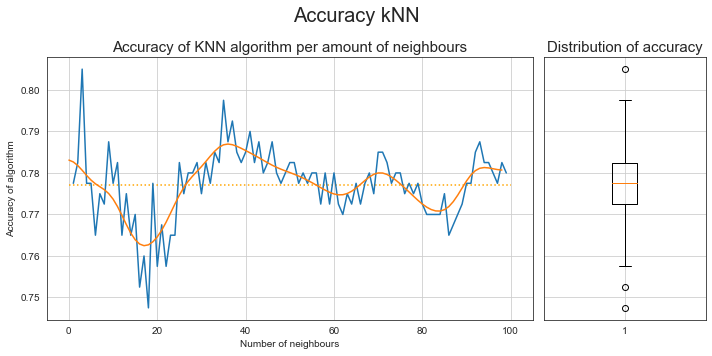

In [181]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True, gridspec_kw={'width_ratios': [3, 1]})
plt.suptitle('Accuracy kNN',size=20)

ax[0].plot(neighbours,scores_list)
y3 = gaussian_filter1d(scores_list, 3) #best number of neighbours is 36
maxy3 = y3.max()
ax[0].plot(y3)
ax[0].hlines(np.average(scores_list),0,100, color='orange',linestyle='dotted')
ax[0].set_title('Accuracy of KNN algorithm per amount of neighbours',size=15)
ax[0].set_xlabel('Number of neighbours')
ax[0].set_ylabel('Accuracy of algorithm')
ax[0].grid()

ax[1].boxplot(scores_list)
ax[1].set_title('Distribution of accuracy',size=15)
ax[1].grid()
plt.tight_layout()
#pd.Series(y3).index(maxy3)
y3, maxy3, scores_list[34:40]

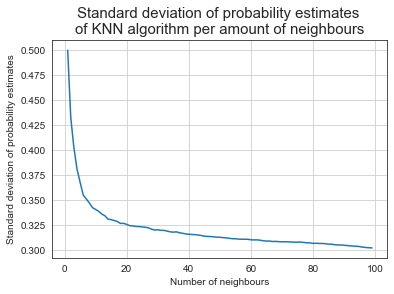

In [119]:
plt.plot(neighbours,std_list)
plt.title('Standard deviation of probability estimates \nof KNN algorithm per amount of neighbours',size=15)
plt.xlabel('Number of neighbours')
plt.ylabel('Standard deviation of probability estimates')
plt.grid()


Average recall is 0.7055654909250161
Average specificity is 0.797866145508005
Average precision is 0.4942222222222223
Average accuracy is 0.7770959595959597
Average accuracy is 0.7770959595959597


(0.7191011235955056, 0.8038585209003215, 0.512, 0.785)

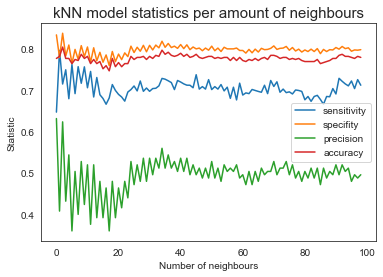

In [140]:

av_recall = []
av_spec = []
av_prec = []
av_acc = []
for confusionmatrix in knn_conf:
    confusionmatrix = pd.DataFrame(confusionmatrix)
    #From: https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = confusionmatrix[0][1]  
    FN = confusionmatrix[1][0]
    TP = confusionmatrix[1][1]
    TN = confusionmatrix[0][0]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    #print('tp',TP,'fn',FN,'tpr',TPR)
    av_recall.append(TPR)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    av_spec.append(TNR)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    av_prec.append(PPV)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    av_acc.append(ACC)
print('Average recall is',np.average(av_recall))
print('Average specificity is',np.average(av_spec))
print('Average precision is',np.average(av_prec))
print('Average accuracy is',np.average(av_acc))
print('Average accuracy is',np.average(scores_list))
plt.plot(av_recall,label='sensitivity')
plt.plot(av_spec,label='specifity')
plt.plot(av_prec,label='precision')
plt.plot(av_acc,label='accuracy')
plt.legend()
plt.title('kNN model statistics per amount of neighbours',size=15)
plt.xlabel('Number of neighbours')
plt.ylabel('Statistic')

av_recall[37],av_spec[37],av_prec[37],av_acc[37]

### Actual model

In [ ]:
knn = KNeighborsClassifier(n_neighbors=i)
## Fit the model on the training data.
knn.fit(X_train, y_train)

output = knn.predict(test_molecules)

# Support vector clustering

In [33]:
from sklearn.svm import SVC

In [78]:
svc_scores_list = []
svc_conf = []
for i in range(1,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=i)
    svc = SVC()
    svc.fit(X_train, y_train)
    svc_scores_list.append(svc.score(X_test,y_test))
    predict = svc.predict(X_test)
    
    cnf = confusion_matrix(y_test,predict)
    svc_conf.append(cnf)

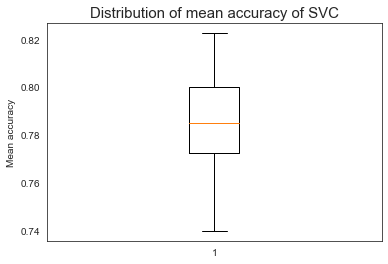

In [79]:
plt.boxplot(svc_scores_list);
plt.title('Distribution of mean accuracy of SVC',size=15);
plt.ylabel('Mean accuracy');

Average recall is 0.6674155983537408
Average specificity is 0.8276885534492581
Average precision is 0.5764666899208641
Average accuracy is 0.7854040404040402


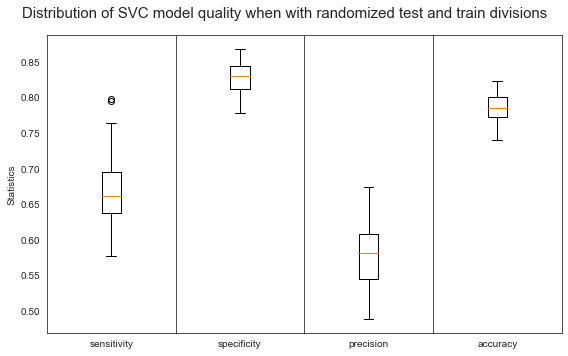

In [178]:
av_recall = []
av_spec = []
av_prec = []
av_acc = []
for confusionmatrix in svc_conf:
    confusionmatrix = pd.DataFrame(confusionmatrix)
    #From: https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = confusionmatrix[0][1]  
    FN = confusionmatrix[1][0]
    TP = confusionmatrix[1][1]
    TN = confusionmatrix[0][0]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    av_recall.append(TPR)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    av_spec.append(TNR)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    av_prec.append(PPV)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    av_acc.append(ACC)
print('Average recall is',np.average(av_recall))
print('Average specificity is',np.average(av_spec))
print('Average precision is',np.average(av_prec))
print('Average accuracy is',np.average(av_acc))

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(1, 4, wspace=0)
ax = gs.subplots(sharey=True)
ax[0].boxplot(av_recall,labels=['sensitivity'])
ax[1].boxplot(av_spec,labels=['specificity'])
ax[2].boxplot(av_prec,labels=['precision'])
ax[3].boxplot(av_acc,labels=['accuracy'])
plt.suptitle('Distribution of SVC model quality when with randomized test and train divisions',size=15)
ax[0].set_ylabel('Statistics')
plt.tight_layout()